<a href="https://colab.research.google.com/github/uprestel/AutoNeRF/blob/master/generate_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Install and Import modules

If `torch`, `torchvision` and `pytorch3d` are not installed, run the following cell:

In [1]:
#!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png


import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader
)

# add path for demo utils functions 
import sys
import os
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(''))

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-4683u7cs
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-4683u7cs
  Running command git checkout -q 686c8666d31d932ed42d3cd7319f249fc75e89a9
     |████████████████████████████████| 276kB 11.4MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.2.0-cp36-cp36m-linux_x86_64.whl size=10165459 sha256=770eaeefee18fa79affbcc411f627eb719aef82a06550aa77ab042cec9c369cc
  Stored in directory: /tmp/pip-ephem-wheel-cache-dbki_cju/wheels/89/69/08/d864f516508b5d943259c6088baa150ebdd3659b5dde4e3571
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=5535d28b5c57217b639ce491ed023ba4fd9c349aa0e3f2087f7cff3663471c1a
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl siz

In [2]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)
texture_image=mesh.textures.maps_padded()

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np


class AutoNeRF_Dataset(Dataset):
    def __init__(self, pth=None):
        self.pth = None
        self.images = None
        self.poses = None
        self.focal_length = None
        
        if pth is not None:
            self.pth = pth
            loaded = np.load(self.pth)

            self.images = loaded["images"]
            self.poses = loaded["poses"]
            self.focal_length = loaded["focal"]


    def __getitem__(self, index):
        image = self.images[index]
        pose = self.poses[index]

        return image, pose


    def __len__(self):
        if self.images is not None:
            return self.images.shape[0]
        return 0

    def save(self):
        np.savez_compressed(self.pth,
                            images = self.images,
                            poses = self.poses,
                            focal_length = self.focal_length
                            )


## 6. Batched Rendering

One of the core design choices of the PyTorch3D API is to support **batched inputs for all components**. 
The renderer and associated components can take batched inputs and **render a batch of output images in one forward pass**. We will now use this feature to render the mesh from many different viewpoints.


In [22]:
# Get a batch of viewing angles. 
batch_size=20
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)


raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)


# load the mesh and extend it for the batch
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "cow_mesh/cow.obj")
mesh = load_objs_as_meshes([obj_filename], device=device)
meshes = mesh.extend(batch_size)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


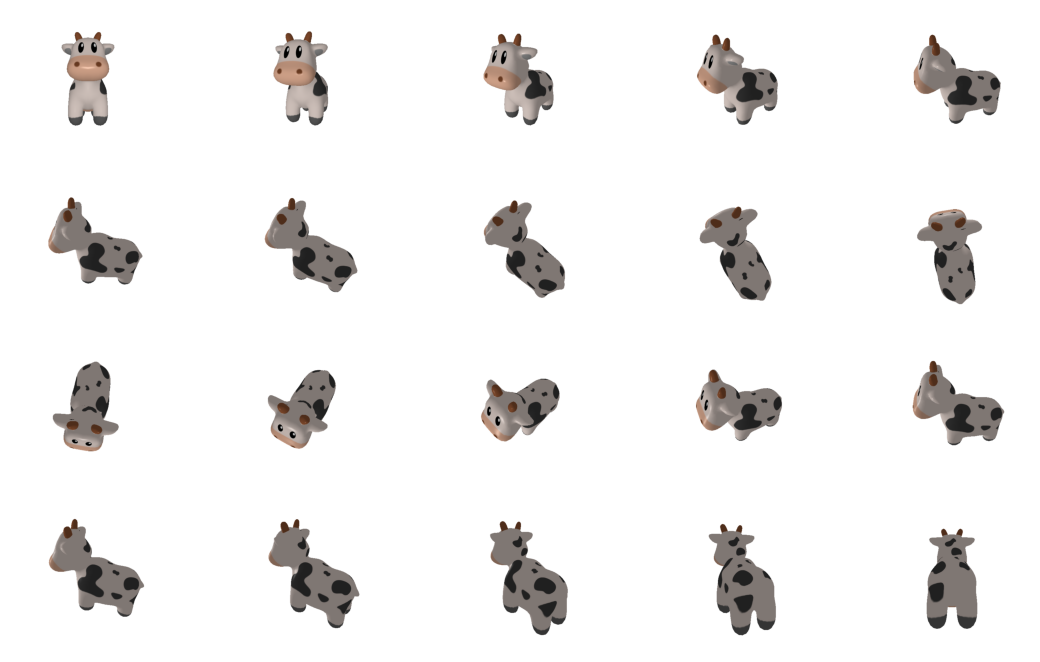

In [7]:
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

In [25]:
from google.colab import drive
drive.mount('/gdrive')

# first we calculate the poses corresponding to the images
world2cam = cameras.get_world_to_view_transform().get_matrix().squeeze(dim=0)
world2cam = torch.transpose(world2cam, 1,2)
cam2world = torch.inverse(world2cam)

# next we calculate the focal length
proj_transform = cameras.get_projection_transform().get_matrix()
focal_length = proj_transform[0][0][0]
print(focal_length)


# finally, we save all the data in our dataset
dataset = AutoNeRF_Dataset(pth=None)

dataset.images = images.cpu().numpy()
dataset.focal_length = focal_length.cpu().numpy()
dataset.poses = cam2world.cpu().numpy()

pth = "/gdrive/My Drive/autonerf.npz"
dataset.pth = pth
dataset.save()



Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
tensor(1.7321, device='cuda:0')
